## free-marketing-watch
Search social media for mentions of brands and collect the comments/tweets/etc.
Count mentions of each and perform sentiment analysis on the strings.

In [ ]:
import praw
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from secrets import *
from pathlib import Path
from brands import fashion
import re

In [ ]:
reddit = praw.Reddit(client_id=client_id,
               client_secret=client_secret,
               user_agent=user_agent)

Now to get the comments data, put it in a dataframe, and clean the data to get what we want.

In [ ]:
def create_comments_df(subreddit_):
    """Returns a pandas df with the information about comments from this year.

    Inputs
    -----
    str: subreddit to be searched.
    Return
    ------
    Pandas dataframe with all the data from the praw object.m
    """
    subreddit = reddit.subreddit(subreddit_)
    submission_list = subreddit.top(
        time_filter="year", limit=1000
    )  # generator of submissions in the subreddit
    comment_list = []
    for submission in submission_list:
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            comment_list.append(comment)

    df = pd.DataFrame([vars(comment) for comment in comment_list])
    df2 = df.loc[:,['link_id','id','score','body']]
    df2['Subreddit'] = subreddit_
    return df2


In [ ]:
def brand_check(df,brandlist):
    """Checks comment body against a list of brands to see if it mentions any.
       Adds what brand was found if any in the brands column.
       
       Inputs
       ------
       Dataframe you will search over and a list of brands in a separate file. 
       Return
       ------
       Dataframe with column indicating what brand was found in the values.
       """

    df2 = df.body.str.extractall(pat=brandlist, flags=re.VERBOSE)
    df2.dropna(axis=0,how='all',inplace=True)
    return df2

### This takes a long time, probably around 30 minutes per 100,000 comments.

In [ ]:
df = create_comments_df('malefashionadvice')
df

Run to export the df to csv. Careful about overwriting. Use the mode = 'a' line to add to an existing file.


In [ ]:
p = Path.cwd() / 'data' / 'commentdf.csv'
#df1.to_csv(path_or_buf = p)
df1.to_csv(path_or_buf = p, mode = 'a', header=False)

In [ ]:
p = Path.cwd() / 'data' / 'commentdf.csv'
df = pd.read_csv(p)
df

If you prefer pickling over csv, use these cells for IO

In [ ]:
p = Path.cwd() / 'data' / 'commentdf.pkl'
df.to_pickle(path = p)

In [ ]:
df = pd.read_pickle(filepath_or_buffer=p)

If you read from CSV it created an extra column so this cell drops it.

In [ ]:
df = df.drop(columns =['Unnamed: 0'])

In [ ]:
df2 = brand_check(df,fashion)

### Drop any columns that didn't find a match.

In [ ]:
pd.set_option("display.max_rows",50, "display.max_columns", None)
df2.dropna(axis=1,how='all',inplace=True)
df2

In [ ]:
overall_counts = df2.count().sort_values(ascending=False)

### Test: Extracting brands from WAYWT threads in malefashionadvice and femalefashionadvice.

In [ ]:
filt = (df['Subreddit'] == 'malefashionadvice')
mfa_df = df[filt]
filt2 = (df['Subreddit'] == 'femalefashionadvice')
ffa_df = df[filt2]

In [ ]:
mfa_df = brand_check(mfa_df,fashion)
ffa_df = brand_check(ffa_df,fashion)

In [ ]:
mfa_df.dropna(axis=1,how='all',inplace=True)
ffa_df.dropna(axis=1,how='all',inplace=True)

In [ ]:
mfa_counts = mfa_df.count().sort_values(ascending=False)
ffa_counts = ffa_df.count().sort_values(ascending=False)

In [ ]:
pd.set_option("display.max_rows",117)
counts_df = pd.concat([overall_counts,mfa_counts,ffa_counts],axis='columns',sort=False)

## Final dataframe with the number of mentions for each brand split into overall, r/malefashionadvice, and r/femalefashionadvice. Ready for data visualization.

In [ ]:
counts_df.to_pickle(Path.cwd() / 'data' / 'countsdf.pkl')
#counts_df = pd.read_pickle(Path.cwd() / 'data' / 'countsdf.pkl')

In [ ]:
pd.set_option("display.max_rows",75)
counts_df.columns = ['Total','r/malefashionadvice','r/femalefashionadvice']
counts_df.sort_values(by='Total',inplace=True)

In [ ]:
counts_df = counts_df.iloc[-30:,1:3]

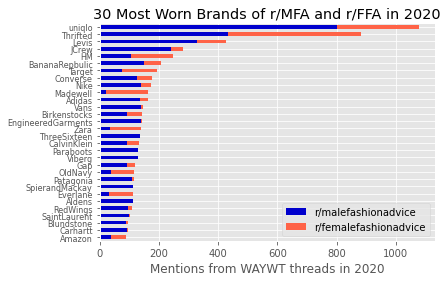

In [37]:
plt.style.use('ggplot')
ax = counts_df.plot.barh(stacked=True,color={r"r/femalefashionadvice":"tomato",r"r/malefashionadvice":"mediumblue"},title='30 Most Worn Brands of r/MFA and r/FFA in 2020')
plt.xlabel('Mentions from WAYWT threads in 2020')
plt.yticks(fontsize=8)
plt.savefig('waywt.png',dpi=300,bbox_inches="tight")